# USAD

In [ ]:
'''
## 최초 1회 실행
!rm -r sample_data
'''

## Environment

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn

from utils import *
from usad import *

## EDA - Data Pre-Processing

### Down load datasets

In [2]:
'''
## 최초 1회 실행
!mkdir input
#normal period
!python gdrivedl.py https://drive.google.com/open?id=1rVJ5ry5GG-ZZi5yI4x9lICB8VhErXwCw input/
#anomalies
!python gdrivedl.py https://drive.google.com/open?id=1iDYc0OEmidN712fquOBRFjln90SbpaE7 input/
'''

'\n## 최초 1회 실행\n!mkdir input\n#normal period\n!python gdrivedl.py https://drive.google.com/open?id=1rVJ5ry5GG-ZZi5yI4x9lICB8VhErXwCw input/\n#anomalies\n!python gdrivedl.py https://drive.google.com/open?id=1iDYc0OEmidN712fquOBRFjln90SbpaE7 input/\n'

### Normal period

In [3]:
data_path = "C:\\Users\\PC0\\Documents\\GitHub\\datasets\\"

#Read data
normal = pd.read_csv(data_path + "SWaT_Dataset_Normal_v1.csv")#, nrows=1000)
normal = normal.drop(["Timestamp" , "Normal/Attack" ] , axis = 1)
normal.shape

C:\Users\PC0\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (26) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(495000, 51)

In [4]:
# Transform all columns into float64
for i in list(normal): 
    normal[i]=normal[i].apply(lambda x: str(x).replace("," , "."))
normal = normal.astype(float)

#### Normalization

In [5]:
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()

x = normal.values
x_scaled = min_max_scaler.fit_transform(x)
normal = pd.DataFrame(x_scaled)

In [6]:
normal.head(2)

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,50
0,0.0,0.005294,0.5,0.0,0.0,0.012291,0.075099,0.002009,0.0,0.5,...,0.0,0.0,0.0,0.000814,0.0,0.001217,0.000147,0.0,0.0,0.0
1,0.0,0.005407,0.5,0.0,0.0,0.012291,0.075099,0.002009,0.0,0.5,...,0.0,0.0,0.0,0.000814,0.0,0.001217,0.000147,0.0,0.0,0.0


### Attack

In [7]:
#Read data
attack = pd.read_csv(data_path + "SWaT_Dataset_Attack_v0.csv",sep=";")#, nrows=1000)
attack = attack.drop(["Timestamp" , "Normal/Attack" ] , axis = 1)
attack.shape

C:\Users\PC0\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (1,9,28,46) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(449919, 51)

In [8]:
# Transform all columns into float64
for i in list(attack):
    attack[i]=attack[i].apply(lambda x: str(x).replace("," , "."))
attack = attack.astype(float)

#### Normalization

In [9]:
from sklearn import preprocessing

x = attack.values 
x_scaled = min_max_scaler.transform(x)
attack = pd.DataFrame(x_scaled)

In [10]:
attack.head(2)

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,50
0,0.884144,0.577133,1.0,1.0,0.0,0.496158,0.188845,0.064088,0.982899,1.0,...,0.970903,1.0,0.0,0.946125,0.449782,0.944116,0.000073,0.0,0.0,0.0
1,0.891145,0.577190,1.0,1.0,0.0,0.496158,0.188845,0.064088,0.982899,1.0,...,0.970903,1.0,0.0,0.946125,0.449782,0.944521,0.000073,0.0,0.0,0.0


### Windows

In [11]:
window_size=12

In [12]:
windows_normal=normal.values[np.arange(window_size)[None, :] + np.arange(normal.shape[0]-window_size)[:, None]]
windows_normal.shape

(494988, 12, 51)

In [13]:
windows_attack=attack.values[np.arange(window_size)[None, :] + np.arange(attack.shape[0]-window_size)[:, None]]
windows_attack.shape

(449907, 12, 51)

## Training

In [14]:
import torch.utils.data as data_utils

BATCH_SIZE =  7919
N_EPOCHS = 100
hidden_size = 10

w_size=windows_normal.shape[1]*windows_normal.shape[2]
z_size=windows_normal.shape[1]*hidden_size

windows_normal_train = windows_normal[:int(np.floor(.8 * .5 * windows_normal.shape[0]))]
windows_normal_val = windows_normal[int(np.floor(.8 * .5 * windows_normal.shape[0])):int(np.floor(.5 * windows_normal.shape[0]))]
windows_normal_test = windows_normal[int(np.floor(.5 * windows_normal.shape[0])):]

train_loader = torch.utils.data.DataLoader(data_utils.TensorDataset(
    torch.from_numpy(windows_normal_train).float().view(([windows_normal_train.shape[0],w_size]))
) , batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

val_loader = torch.utils.data.DataLoader(data_utils.TensorDataset(
    torch.from_numpy(windows_normal_val).float().view(([windows_normal_val.shape[0],w_size]))
) , batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

test_loader = torch.utils.data.DataLoader(data_utils.TensorDataset(
    torch.from_numpy(np.concatenate([windows_normal_test,windows_attack])).float().view(([windows_normal_test.shape[0]+windows_attack.shape[0],w_size]))
) , batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

model = UsadModel(w_size, z_size)
model = to_device(model,device)

In [15]:
history = training(N_EPOCHS,model,train_loader,val_loader)

Epoch [0], val_loss1: 0.0633, val_loss2: 0.0638
Epoch [1], val_loss1: 0.0415, val_loss2: -0.0004
Epoch [2], val_loss1: 0.0330, val_loss2: -0.0130
Epoch [3], val_loss1: 0.0343, val_loss2: -0.0194
Epoch [4], val_loss1: 0.0345, val_loss2: -0.0228
Epoch [5], val_loss1: 0.0363, val_loss2: -0.0259
Epoch [6], val_loss1: 0.0359, val_loss2: -0.0268
Epoch [7], val_loss1: 0.0356, val_loss2: -0.0281
Epoch [8], val_loss1: 0.0352, val_loss2: -0.0286
Epoch [9], val_loss1: 0.0346, val_loss2: -0.0286
Epoch [10], val_loss1: 0.0337, val_loss2: -0.0285
Epoch [11], val_loss1: 0.0328, val_loss2: -0.0281
Epoch [12], val_loss1: 0.0241, val_loss2: -0.0214
Epoch [13], val_loss1: 0.0179, val_loss2: -0.0154
Epoch [14], val_loss1: 0.0173, val_loss2: -0.0151
Epoch [15], val_loss1: 0.0171, val_loss2: -0.0152
Epoch [16], val_loss1: 0.0181, val_loss2: -0.0164
Epoch [17], val_loss1: 0.0193, val_loss2: -0.0176
Epoch [18], val_loss1: 0.0177, val_loss2: -0.0164
Epoch [19], val_loss1: 0.0190, val_loss2: -0.0173
Epoch [20],

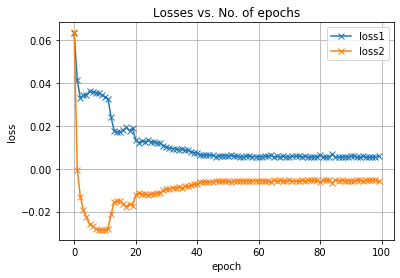

In [16]:
plot_history(history)

In [17]:
torch.save({
            'encoder': model.encoder.state_dict(),
            'decoder1': model.decoder1.state_dict(),
            'decoder2': model.decoder2.state_dict()
            }, "model.pth")

## Testing

In [18]:
checkpoint = torch.load("model.pth")

model.encoder.load_state_dict(checkpoint['encoder'])
model.decoder1.load_state_dict(checkpoint['decoder1'])
model.decoder2.load_state_dict(checkpoint['decoder2'])

<All keys matched successfully>

In [19]:
results=testing(model,test_loader)

In [20]:
y_pred=np.concatenate([torch.stack(results[:-1]).flatten().detach().cpu().numpy(),
                              results[-1].flatten().detach().cpu().numpy()])
y_test=np.concatenate([np.zeros(windows_normal_test.shape[0]),
                       np.ones(windows_attack.shape[0])])

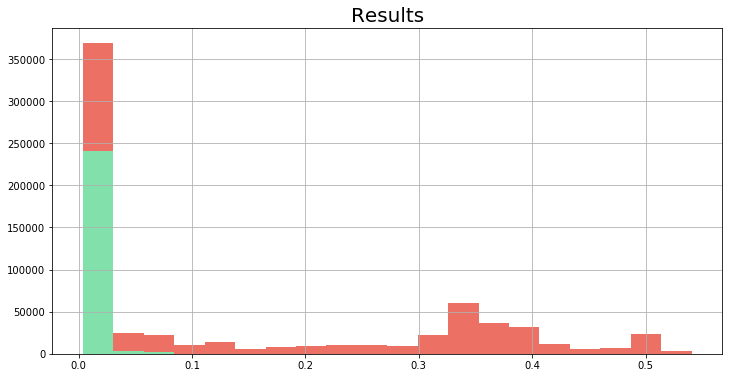

In [21]:
histogram(y_test,y_pred)

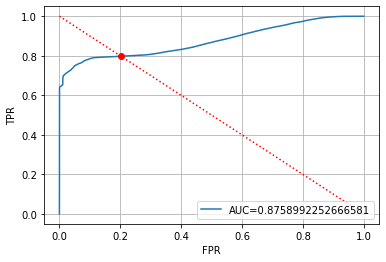

In [22]:
threshold=ROC(y_test,y_pred)

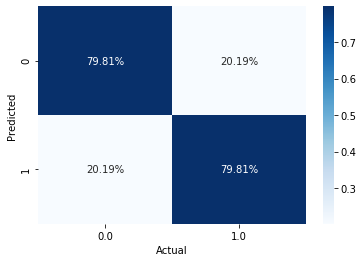

In [23]:
confusion_matrix(y_test,np.where(y_pred > threshold, 1, 0),perc=True)

## Anomaly gap maximize net

* 제안 아이디어 검증

In [24]:
class UsadModel_AGM(nn.Module):
    def __init__(self, w_size, z_size):
        super().__init__()
        self.encoder = Encoder(w_size, z_size)
        self.decoder1 = Decoder(z_size, w_size)
        self.decoder2 = Decoder(z_size, w_size)

    def training_step(self, batch, n):
        z = self.encoder(batch)
        w1 = self.decoder1(z)
        w2 = self.decoder2(z)
        w3 = self.decoder2(self.encoder(w1))
        real_recon1 = batch-w1
        real_recon2 = batch-w2
        fake_recon = batch-w3
        
        with torch.no_grad():
            pg_advantage = torch.mean((fake_recon)**2)-torch.mean((real_recon2)**2)
        
        loss1 = 1/n*torch.mean((real_recon1)**2)+(1-1/n)*torch.mean((fake_recon)**2) # AE1 - generator
        loss2 = 1/n*torch.mean((real_recon2)**2)-(1-1/n)*torch.mean((fake_recon)**2) # AE2 - discriminator
        loss3 = -torch.mean(torch.log(w3+1e-6) * pg_advantage)
        #loss3 = -torch.sum(torch.log(w3+1e-6) * pg_advantage)
        
        return loss1,loss2,loss3

    def validation_step(self, batch, n):
        z = self.encoder(batch)
        w1 = self.decoder1(z)
        w2 = self.decoder2(z)
        w3 = self.decoder2(self.encoder(w1))
        
        real_recon1 = batch-w1
        real_recon2 = batch-w2
        fake_recon = batch-w3
        
        pg_advantage = torch.mean((fake_recon)**2)-torch.mean((real_recon2)**2)
        
        loss1 = 1/n*torch.mean((real_recon1)**2)+(1-1/n)*torch.mean((fake_recon)**2) # AE1 - generator
        loss2 = 1/n*torch.mean((real_recon2)**2)-(1-1/n)*torch.mean((fake_recon)**2) # AE2 - discriminator
        loss3 = -torch.mean(torch.log(w3+1e-6) * pg_advantage)
        #loss3 = -torch.sum(torch.log(w3+1e-6) * pg_advantage)
        
        return {'val_loss1': loss1, 'val_loss2': loss2, 'val_loss3': loss3}

    def validation_epoch_end(self, outputs):
        batch_losses1 = [x['val_loss1'] for x in outputs]
        epoch_loss1 = torch.stack(batch_losses1).mean()
        batch_losses2 = [x['val_loss2'] for x in outputs]
        epoch_loss2 = torch.stack(batch_losses2).mean()
        batch_losses3 = [x['val_loss3'] for x in outputs]
        epoch_loss3 = torch.stack(batch_losses3).mean()
        return {'val_loss1': epoch_loss1.item(), 'val_loss2': epoch_loss2.item(), 'val_loss3': epoch_loss3.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss1: {:.4f}, val_loss2: {:.4f}, val_loss3: {:.4f}".format(epoch, result['val_loss1'], result['val_loss2'], result['val_loss3']))
    
def evaluate(model, val_loader, n):
    outputs = [model.validation_step(to_device(batch,device), n) for [batch] in val_loader]
    return model.validation_epoch_end(outputs)

def training(epochs, model, train_loader, val_loader, opt_func=torch.optim.Adam, max_norm = 3):
    history = []
    optimizer1 = opt_func(list(model.encoder.parameters())+list(model.decoder1.parameters()))
    optimizer2 = opt_func(list(model.encoder.parameters())+list(model.decoder2.parameters()))
    for epoch in range(epochs):
        for [batch] in train_loader:
            batch=to_device(batch,device)
            loss1,loss2,loss3 = model.training_step(batch,epoch+1)
            loss1.backward(retain_graph=True)
            loss2.backward(retain_graph=True)
            loss3.backward()
            
            ## gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)
            
            optimizer1.step()
            optimizer2.step()
            optimizer1.zero_grad()
            optimizer2.zero_grad()
        result = evaluate(model, val_loader, epoch+1)
        model.epoch_end(epoch, result)
        history.append(result)
    return history
    
def testing(model, test_loader, alpha=.5, beta=.5):
    results=[]
    for [batch] in test_loader:
        batch=to_device(batch,device)
        w1=model.decoder1(model.encoder(batch))
        w2=model.decoder2(model.encoder(w1))
        results.append(alpha*torch.mean((batch-w1)**2,axis=1)+beta*torch.mean((batch-w2)**2,axis=1))
    return results

In [25]:
import torch.utils.data as data_utils

BATCH_SIZE = 7919
N_EPOCHS = 100
hidden_size = 10

w_size=windows_normal.shape[1]*windows_normal.shape[2]
z_size=windows_normal.shape[1]*hidden_size

windows_normal_train = windows_normal[:int(np.floor(.8 * .5 * windows_normal.shape[0]))]
windows_normal_val = windows_normal[int(np.floor(.8 * .5 * windows_normal.shape[0])):int(np.floor(.5 * windows_normal.shape[0]))]
windows_normal_test = windows_normal[int(np.floor(.5 * windows_normal.shape[0])):]

train_loader = torch.utils.data.DataLoader(data_utils.TensorDataset(
    torch.from_numpy(windows_normal_train).float().view(([windows_normal_train.shape[0],w_size]))
) , batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

val_loader = torch.utils.data.DataLoader(data_utils.TensorDataset(
    torch.from_numpy(windows_normal_val).float().view(([windows_normal_val.shape[0],w_size]))
) , batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

test_loader = torch.utils.data.DataLoader(data_utils.TensorDataset(
    torch.from_numpy(np.concatenate([windows_normal_test,windows_attack])).float().view(([windows_normal_test.shape[0]+windows_attack.shape[0],w_size]))
) , batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

model = UsadModel_AGM(w_size, z_size)
model = to_device(model,device)

In [26]:
history = training(N_EPOCHS,model,train_loader,val_loader)

Epoch [0], val_loss1: 0.0505, val_loss2: 0.0510, val_loss3: 0.0014
Epoch [1], val_loss1: 0.0339, val_loss2: -0.0008, val_loss3: 0.0016
Epoch [2], val_loss1: 0.0347, val_loss2: -0.0133, val_loss3: 0.0035
Epoch [3], val_loss1: 0.3270, val_loss2: -0.3073, val_loss3: 0.0000
Epoch [4], val_loss1: 0.3457, val_loss2: -0.2540, val_loss3: 0.0000
Epoch [5], val_loss1: 0.3581, val_loss2: -0.2822, val_loss3: 0.0000
Epoch [6], val_loss1: 0.3674, val_loss2: -0.3024, val_loss3: 0.0000
Epoch [7], val_loss1: 0.3744, val_loss2: -0.3175, val_loss3: 0.0000
Epoch [8], val_loss1: 0.3798, val_loss2: -0.3293, val_loss3: 0.0000
Epoch [9], val_loss1: 0.3841, val_loss2: -0.3387, val_loss3: 0.0000
Epoch [10], val_loss1: 0.3876, val_loss2: -0.3464, val_loss3: 0.0000
Epoch [11], val_loss1: 0.3905, val_loss2: -0.3528, val_loss3: 0.0000
Epoch [12], val_loss1: 0.3923, val_loss2: -0.3582, val_loss3: -0.0000
Epoch [13], val_loss1: 0.0391, val_loss2: -0.0336, val_loss3: -0.0002
Epoch [14], val_loss1: 0.0366, val_loss2: -

* print each step

In [76]:
results = []
w1_list = []
w2_list = []
batch_list = []
for [batch] in val_loader:
    batch=to_device(batch,device)
    w1=model.decoder1(model.encoder(batch))
    w2=model.decoder2(model.encoder(w1))
    results.append(.5*torch.mean((batch-w1)**2,axis=1)+.5*torch.mean((batch-w2)**2,axis=1))
    batch_list.append(batch)
    w1_list.append(w1)
    w2_list.append(w2)

In [80]:
np.round(w1_list[0].detach().numpy(),3)

array([[0.725, 0.611, 0.903, ..., 0.   , 0.   , 0.   ],
       [0.726, 0.611, 0.903, ..., 0.   , 0.   , 0.   ],
       [0.726, 0.61 , 0.903, ..., 0.   , 0.   , 0.   ],
       ...,
       [0.673, 0.656, 0.874, ..., 0.   , 0.   , 0.   ],
       [0.671, 0.658, 0.873, ..., 0.   , 0.   , 0.   ],
       [0.667, 0.662, 0.87 , ..., 0.   , 0.   , 0.   ]], dtype=float32)

In [81]:
np.round(w2_list[0].detach().numpy(),3)

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]], dtype=float32)

In [78]:
batch_list[0]

tensor([[0.8922, 0.5583, 1.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.8872, 0.5582, 1.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.8819, 0.5580, 1.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.8866, 0.5483, 1.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.8848, 0.5483, 1.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.8841, 0.5480, 1.0000,  ..., 0.0000, 1.0000, 0.0000]])

In [82]:
n = 100
z = model.encoder(batch)
w1 = model.decoder1(z)
w2 = model.decoder2(z)
w3 = model.decoder2(model.encoder(w1))

real_recon1 = batch-w1
real_recon2 = batch-w2
fake_recon = batch-w3

pg_advantage = torch.mean((fake_recon)**2)-torch.mean((real_recon2)**2)

loss1 = 1/n*torch.mean((real_recon1)**2)+(1-1/n)*torch.mean((fake_recon)**2) # AE1 - generator
loss2 = 1/n*torch.mean((real_recon2)**2)-(1-1/n)*torch.mean((fake_recon)**2) # AE2 - discriminator
loss3 = -torch.mean(torch.log(w3+1e-6) * pg_advantage)

In [83]:
loss1

tensor(0.4198, grad_fn=<AddBackward0>)

In [84]:
loss2

tensor(-0.4154, grad_fn=<SubBackward0>)

In [85]:
torch.mean((fake_recon)**2)

tensor(0.4238, grad_fn=<MeanBackward0>)

In [86]:
torch.mean((real_recon2)**2)

tensor(0.4238, grad_fn=<MeanBackward0>)

In [87]:
-torch.sum(torch.log(w3+1e-6)*pg_advantage)

tensor(-0., grad_fn=<NegBackward>)

In [88]:
torch.log(w3+1e-6)

tensor([[9.5367e-07, 9.5367e-07, 9.5367e-07,  ..., 9.5367e-07, 9.5367e-07,
         9.5367e-07],
        [9.5367e-07, 9.5367e-07, 9.5367e-07,  ..., 9.5367e-07, 9.5367e-07,
         9.5367e-07],
        [9.5367e-07, 9.5367e-07, 9.5367e-07,  ..., 9.5367e-07, 9.5367e-07,
         9.5367e-07],
        ...,
        [9.5367e-07, 9.5367e-07, 9.5367e-07,  ..., 9.5367e-07, 9.5367e-07,
         9.5367e-07],
        [9.5367e-07, 9.5367e-07, 9.5367e-07,  ..., 9.5367e-07, 9.5367e-07,
         9.5367e-07],
        [9.5367e-07, 9.5367e-07, 9.5367e-07,  ..., 9.5367e-07, 9.5367e-07,
         9.5367e-07]], grad_fn=<LogBackward>)

In [89]:
pg_advantage

tensor(0., grad_fn=<SubBackward0>)

In [27]:
def plot_history_2(history):
    losses1 = [x['val_loss1'] for x in history]
    losses2 = [x['val_loss2'] for x in history]
    losses3 = [x['val_loss3'] for x in history]
    plt.plot(losses1, '-x', label="loss1")
    plt.plot(losses2, '-x', label="loss2")
    plt.plot(losses3, '-x', label="loss2")
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()
    plt.title('Losses vs. No. of epochs')
    plt.grid()
    plt.show()

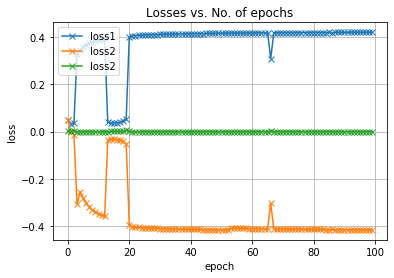

In [28]:
plot_history_2(history)

In [18]:
torch.save({
            'encoder': model.encoder.state_dict(),
            'decoder1': model.decoder1.state_dict(),
            'decoder2': model.decoder2.state_dict()
            }, "model_agm_1.pth")

## Testing

In [19]:
checkpoint = torch.load("model_agm_1.pth")

model.encoder.load_state_dict(checkpoint['encoder'])
model.decoder1.load_state_dict(checkpoint['decoder1'])
model.decoder2.load_state_dict(checkpoint['decoder2'])

<All keys matched successfully>

In [20]:
results=testing(model,test_loader)

In [21]:
y_pred=np.concatenate([torch.stack(results[:-1]).flatten().detach().cpu().numpy(),
                              results[-1].flatten().detach().cpu().numpy()])
y_test=np.concatenate([np.zeros(windows_normal_test.shape[0]),
                       np.ones(windows_attack.shape[0])])

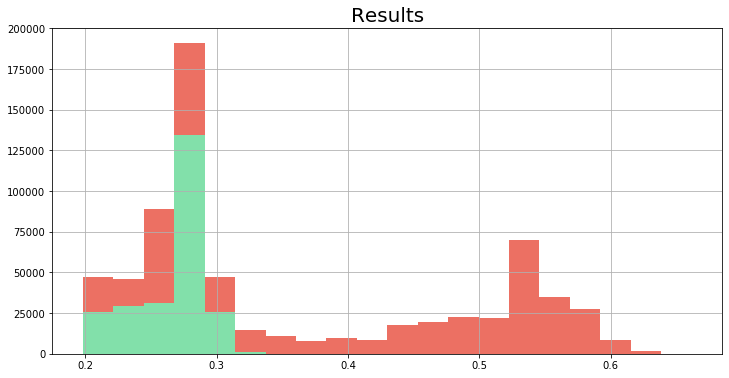

In [22]:
histogram(y_test,y_pred)

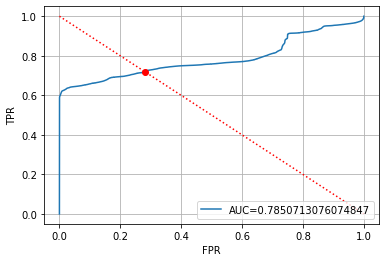

In [23]:
threshold=ROC(y_test,y_pred)

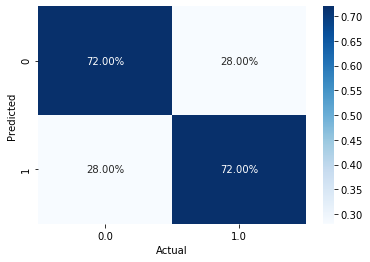

In [24]:
confusion_matrix(y_test,np.where(y_pred > threshold, 1, 0),perc=True)